In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
import os

In [5]:
os.chdir("..")

In [6]:
import numpy as np
import scipy as sp
import scipy.stats
import seaborn as sns
import pandas as pd
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import pickle
from tqdm import tqdm
from sampling.utils import SamplingLogger
import sys
sys.path.append('./sampling')

In [7]:
sns.set_style("ticks")
sns.set_style("white")
sns.set_palette(sns.color_palette("dark", 8))
plt_colors = sns.color_palette()
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams.update({'font.size': 12})

In [16]:
fold_idx = 6

In [17]:
with_sat = pickle.load(open(f"results/fold_{fold_idx}/sampling_with_sat.pkl", "rb"))
no_sat = pickle.load(open(f"results/fold_{fold_idx}/sampling_no_sat.pkl", "rb"))

In [18]:
df = pd.read_csv(f"results/fold_{fold_idx}/sampling_df.csv")

In [19]:
df_results = pd.read_csv("results/fold_%s/test_results.csv" % fold_idx)

In [61]:
print(df_results["state_name"][0], len(df_results))

Gujarat 17841


In [21]:
r2_score(df_results["true"], df_results["smoothed"])

0.2875055828541304

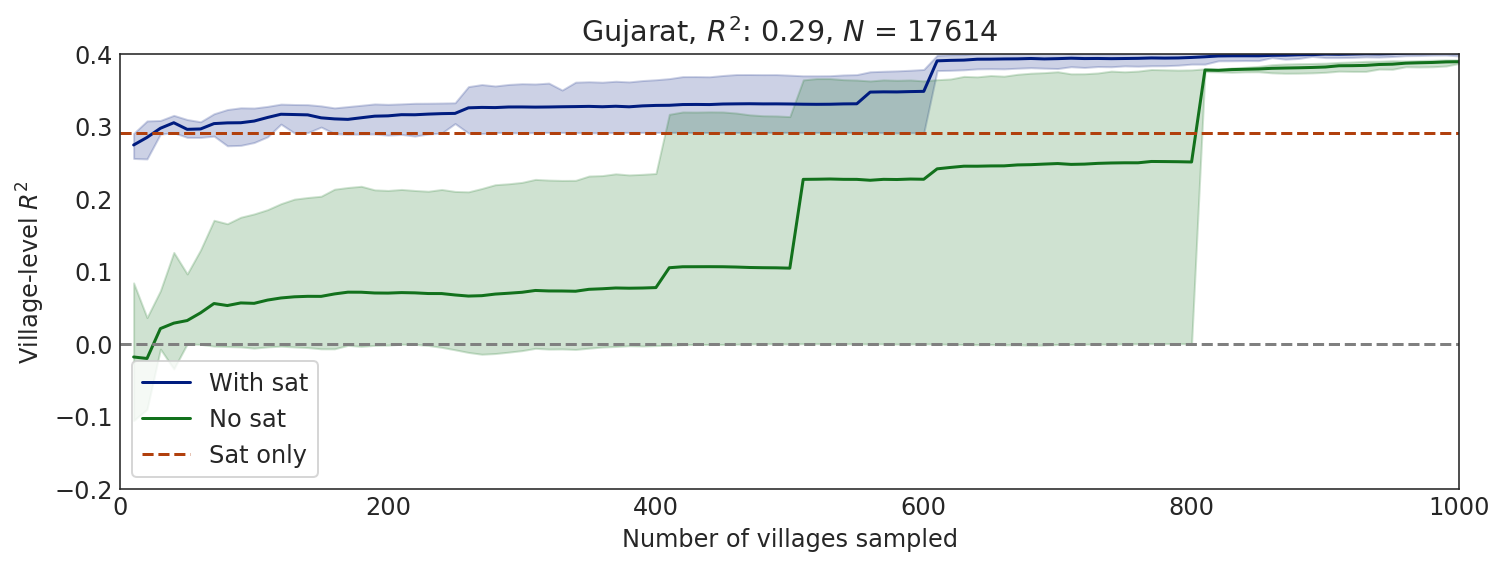

In [24]:
plt.figure(figsize=(12, 4))
sns.lineplot(x = "batch_no", y = "r2", label = "With sat", color = plt_colors[0],
             data = {"r2": with_sat.r2s, "batch_no": with_sat.batch_nos * with_sat.arguments["batch_size"]})
sns.lineplot(x = "batch_no", y = "r2", label = "No sat", color = plt_colors[2],
             data = {"r2": no_sat.r2s, "batch_no": no_sat.batch_nos * no_sat.arguments["batch_size"]})
plt.xlabel("Number of villages sampled")
plt.ylabel("Village-level $R^2$")
plt.axhline(r2_score(df["true"], df["pred"]), ls="--", color=plt_colors[1], label="Sat only")
plt.axhline(0, ls="--", color="grey")
plt.ylim(-0.2, 0.4)
plt.xlim(0, 1000)
plt.title("%s, $R^2$: %.2f, $N$ = %d" % (df_results["state_name"][0], 
                                         r2_score(df_results["true"], df_results["smoothed"]),
                                         len(df)))
plt.legend();

In [112]:
def process_state(fold_idx):
  df_results = pd.read_csv("results/fold_%s/test_results.csv" % fold_idx)
  with_sat = pickle.load(open(f"results/fold_{fold_idx}/sampling_with_sat.pkl", "rb"))
  no_sat = pickle.load(open(f"results/fold_{fold_idx}/sampling_no_sat.pkl", "rb"))
  with_sat_df = pd.DataFrame({"r2": with_sat.r2s, "batch_no": with_sat.batch_nos})
  no_sat_df = pd.DataFrame({"r2": no_sat.r2s, "batch_no": no_sat.batch_nos})
  batch_size = with_sat.arguments["batch_size"]
  ret_dict = {}
  ret_dict["state"] = df_results["state_name"][0]
  ret_dict["sat_r2"] = round(r2_score(df_results["true"], df_results["smoothed"]), 3)
  ret_dict["n_villages"] = len(df_results)
  for sample_no in (50, 100, 250, 1000):
    with_mean = np.mean(with_sat_df[with_sat_df["batch_no"] == sample_no // batch_size]["r2"])
    with_sd = np.std(with_sat_df[with_sat_df["batch_no"] == sample_no // batch_size]["r2"])
    no_mean = np.mean(no_sat_df[no_sat_df["batch_no"] == sample_no // batch_size]["r2"])
    no_sd = np.std(no_sat_df[no_sat_df["batch_no"] == sample_no // batch_size]["r2"])
    if np.isnan(with_mean) or np.isnan(no_mean):
      return {}
    ret_dict[f"with_sat_{sample_no}"] = f"{with_mean:.2f} ± {with_sd:.2f}"
    ret_dict[f"no_sat_{sample_no}"] = f"{no_mean:.2f} ± {no_sd:.2f}"
  return ret_dict

In [113]:
results_df = pd.DataFrame(columns=["state", "sat_r2", "n_villages", "with_sat_50", "no_sat_50", 
                                   "with_sat_100", "no_sat_100", "with_sat_250", "no_sat_250",
                                   "with_sat_1000", "no_sat_1000"])

In [114]:
for i in tqdm(range(1, 30)):
  row = process_state(i)
  if row != {}:
    results_df = results_df.append(row, ignore_index=True)

100%|██████████| 29/29 [00:02<00:00,  9.17it/s]


In [118]:
results_df

,state,sat_r2,n_villages,with_sat_50,no_sat_50,with_sat_100,no_sat_100,with_sat_250,no_sat_250,with_sat_1000,no_sat_1000
0,Assam,0.102,23005,0.04 ± 0.09,0.01 ± 0.01,0.13 ± 0.01,0.01 ± 0.02,0.14 ± 0.00,0.02 ± 0.02,0.14 ± 0.00,0.03 ± 0.00
1,Bihar,-0.204,31814,-0.02 ± 0.07,0.03 ± 0.03,-0.02 ± 0.05,0.05 ± 0.01,0.04 ± 0.01,0.04 ± 0.04,0.06 ± 0.01,0.08 ± 0.01
2,Chhattisgarh,-0.007,17891,0.15 ± 0.01,-0.03 ± 0.02,0.16 ± 0.00,-0.01 ± 0.01,0.15 ± 0.00,-0.00 ± 0.00,0.16 ± 0.00,-0.00 ± 0.00
3,Gujarat,0.288,17841,0.30 ± 0.01,0.03 ± 0.05,0.31 ± 0.02,0.06 ± 0.09,0.32 ± 0.02,0.07 ± 0.10,0.40 ± 0.00,0.39 ± 0.00
4,Haryana,-0.205,6579,0.08 ± 0.02,-0.01 ± 0.01,0.07 ± 0.00,-0.00 ± 0.02,0.08 ± 0.02,0.06 ± 0.08,0.14 ± 0.07,0.16 ± 0.11
5,Himachal Pradesh,-0.722,17572,0.05 ± 0.06,-0.01 ± 0.03,0.14 ± 0.02,0.02 ± 0.03,0.17 ± 0.04,0.05 ± 0.06,0.26 ± 0.05,0.17 ± 0.12
6,Jammu and Kashmir,0.041,5727,0.10 ± 0.02,0.18 ± 0.13,0.17 ± 0.09,0.18 ± 0.13,0.28 ± 0.12,0.35 ± 0.03,0.48 ± 0.01,0.48 ± 0.01
7,Jharkhand,0.032,27399,0.07 ± 0.04,-0.01 ± 0.01,0.07 ± 0.03,-0.02 ± 0.01,0.07 ± 0.03,0.01 ± 0.03,0.09 ± 0.03,0.06 ± 0.04
8,Karnataka,-0.082,25803,-0.18 ± 0.16,0.04 ± 0.05,-0.07 ± 0.01,0.09 ± 0.01,-0.05 ± 0.01,0.09 ± 0.00,0.11 ± 0.09,0.17 ± 0.02
9,Kerala,-1.893,1007,0.35 ± 0.06,0.38 ± 0.01,0.47 ± 0.15,0.51 ± 0.15,0.63 ± 0.19,0.79 ± 0.01,0.82 ± 0.00,0.83 ± 0.00
